# Data Preparation for Crypto Clustering Analysis

This notebook handles data quality control and prepares the crypto-markets.csv dataset for clustering analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load and Explore the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('../data/raw/crypto-markets.csv')

# Basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (942297, 13)

Columns: ['slug', 'symbol', 'name', 'date', 'ranknow', 'open', 'high', 'low', 'close', 'volume', 'market', 'close_ratio', 'spread']

Data types:
slug            object
symbol          object
name            object
date            object
ranknow          int64
open           float64
high           float64
low            float64
close          float64
volume         float64
market         float64
close_ratio    float64
spread         float64
dtype: object

First few rows:


,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32


In [3]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Get date range
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {(df['date'].max() - df['date'].min()).days}")

# Unique cryptocurrencies
print(f"\nUnique cryptocurrencies (by slug): {df['slug'].nunique()}")
print(f"Unique symbols: {df['symbol'].nunique()}")
print(f"Total records: {len(df)}")

Date range: 2013-04-28 00:00:00 to 2018-11-30 00:00:00
Total days: 2042

Unique cryptocurrencies (by slug): 2071
Unique symbols: 2005
Total records: 942297


## 2. Data Quality Assessment

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Percentage': missing_percentage
})
print("Missing values analysis:")
print(missing_df[missing_df['Missing_Count'] > 0])

Missing values analysis:
Empty DataFrame
Columns: [Missing_Count, Percentage]
Index: []


In [5]:
# Check for duplicate symbol issues mentioned in README
symbol_analysis = df.groupby('symbol')['slug'].nunique().sort_values(ascending=False)
duplicate_symbols = symbol_analysis[symbol_analysis > 1]
print(f"Symbols with multiple slugs: {len(duplicate_symbols)}")
print("\nTop 10 symbols with most duplicates:")
print(duplicate_symbols.head(10))

Symbols with multiple slugs: 63

Top 10 symbols with most duplicates:
symbol
ACC     3
BIT     3
BITS    3
LNC     2
PXC     2
EVN     2
ETT     2
CMCT    2
BBK     2
CMS     2
Name: slug, dtype: int64


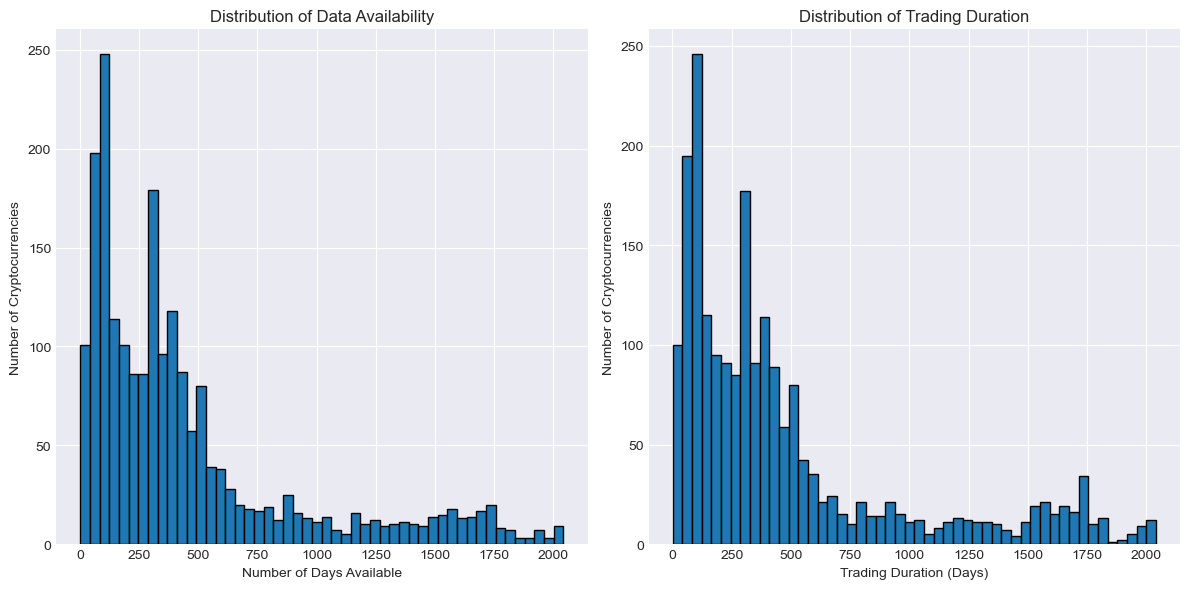

Cryptos with at least 180 days of data: 1383
Cryptos with at least 365 days of data: 872


In [6]:
# Analyze data availability per cryptocurrency
crypto_data_availability = df.groupby('slug').agg({
    'date': ['min', 'max', 'count'],
    'symbol': 'first',
    'name': 'first'
})
crypto_data_availability.columns = ['start_date', 'end_date', 'days_available', 'symbol', 'name']
crypto_data_availability['trading_duration'] = (crypto_data_availability['end_date'] - 
                                               crypto_data_availability['start_date']).dt.days

# Distribution of available data days
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(crypto_data_availability['days_available'], bins=50, edgecolor='black')
plt.xlabel('Number of Days Available')
plt.ylabel('Number of Cryptocurrencies')
plt.title('Distribution of Data Availability')

plt.subplot(1, 2, 2)
plt.hist(crypto_data_availability['trading_duration'], bins=50, edgecolor='black')
plt.xlabel('Trading Duration (Days)')
plt.ylabel('Number of Cryptocurrencies')
plt.title('Distribution of Trading Duration')
plt.tight_layout()
plt.show()

print(f"Cryptos with at least 180 days of data: {len(crypto_data_availability[crypto_data_availability['days_available'] >= 180])}")
print(f"Cryptos with at least 365 days of data: {len(crypto_data_availability[crypto_data_availability['days_available'] >= 365])}")

## 3. Data Cleaning and Quality Control

In [7]:
# Remove records with zero or null prices
print(f"Records before cleaning: {len(df)}")

# Remove rows where critical price columns are zero or null
price_columns = ['open', 'high', 'low', 'close']
df_clean = df.copy()

# Remove rows where all price columns are zero
zero_price_mask = (df_clean[price_columns] == 0).all(axis=1)
df_clean = df_clean[~zero_price_mask]

# Remove rows with null values in critical columns
df_clean = df_clean.dropna(subset=price_columns + ['date', 'slug', 'symbol'])

# Remove rows with invalid price relationships (high < low, etc.)
invalid_price_mask = (df_clean['high'] < df_clean['low']) | \
                    (df_clean['close'] > df_clean['high']) | \
                    (df_clean['close'] < df_clean['low']) | \
                    (df_clean['open'] > df_clean['high']) | \
                    (df_clean['open'] < df_clean['low'])
df_clean = df_clean[~invalid_price_mask]

print(f"Records after cleaning: {len(df_clean)}")
print(f"Records removed: {len(df) - len(df_clean)} ({((len(df) - len(df_clean)) / len(df) * 100):.2f}%)")

Records before cleaning: 942297
Records after cleaning: 942249
Records removed: 48 (0.01%)


In [9]:
# Filter cryptocurrencies with sufficient data (at least 180 days)
MIN_DAYS_REQUIRED = 180

crypto_days = df_clean.groupby('slug')['date'].count()
valid_cryptos = crypto_days[crypto_days >= MIN_DAYS_REQUIRED].index.tolist()

df_filtered = df_clean[df_clean['slug'].isin(valid_cryptos)].copy()

print(f"Cryptocurrencies with at least {MIN_DAYS_REQUIRED} days: {len(valid_cryptos)}")
print(f"Records after filtering: {len(df_filtered)}")

Cryptocurrencies with at least 180 days: 1383
Records after filtering: 879375


In [10]:
# Handle duplicate symbols by creating unique identifiers
# For cryptos with same symbol, append a suffix to make them unique
symbol_counts = df_filtered.groupby(['symbol', 'slug']).size().reset_index(name='count')
duplicate_symbols = symbol_counts.groupby('symbol').filter(lambda x: len(x) > 1)

if len(duplicate_symbols) > 0:
    print(f"Handling {len(duplicate_symbols)} duplicate symbol cases...")
    
    # Create a mapping for unique symbols
    symbol_mapping = {}
    for symbol in duplicate_symbols['symbol'].unique():
        slugs = duplicate_symbols[duplicate_symbols['symbol'] == symbol]['slug'].values
        for i, slug in enumerate(slugs):
            if i > 0:
                symbol_mapping[slug] = f"{symbol}_{i}"
    
    # Apply mapping
    df_filtered['unique_symbol'] = df_filtered.apply(
        lambda row: symbol_mapping.get(row['slug'], row['symbol']), axis=1
    )
else:
    df_filtered['unique_symbol'] = df_filtered['symbol']

Handling 57 duplicate symbol cases...


## 4. Export Year-wise CSV Files

In [11]:
# Create year column
df_filtered['year'] = df_filtered['date'].dt.year

# Get unique years
years = sorted(df_filtered['year'].unique())
print(f"Years in dataset: {years}")

# Export year-wise CSV files
import os
output_dir = '../data/processed/'
os.makedirs(output_dir, exist_ok=True)

for year in years:
    year_data = df_filtered[df_filtered['year'] == year]
    output_file = os.path.join(output_dir, f'crypto_data_{year}.csv')
    year_data.to_csv(output_file, index=False)
    print(f"Exported {year}: {len(year_data)} records, {year_data['slug'].nunique()} cryptocurrencies")

Years in dataset: [2013, 2014, 2015, 2016, 2017, 2018]
Exported 2013: 5483 records, 43 cryptocurrencies
Exported 2014: 43211 records, 191 cryptocurrencies
Exported 2015: 80053 records, 274 cryptocurrencies
Exported 2016: 111994 records, 404 cryptocurrencies
Exported 2017: 212894 records, 952 cryptocurrencies
Exported 2018: 425740 records, 1383 cryptocurrencies


In [12]:
# Also save the complete cleaned dataset
df_filtered.to_csv('../data/processed/crypto_data_cleaned.csv', index=False)
print(f"\nComplete cleaned dataset saved: {len(df_filtered)} records")


Complete cleaned dataset saved: 879375 records


## 5. Data Quality Summary Report

In [13]:
# Generate summary statistics
print("=== DATA QUALITY SUMMARY REPORT ===")
print(f"\n1. Original Dataset:")
print(f"   - Total records: {len(df):,}")
print(f"   - Unique cryptocurrencies: {df['slug'].nunique():,}")
print(f"   - Date range: {df['date'].min()} to {df['date'].max()}")

print(f"\n2. After Cleaning:")
print(f"   - Total records: {len(df_filtered):,}")
print(f"   - Unique cryptocurrencies: {df_filtered['slug'].nunique():,}")
print(f"   - Records removed: {len(df) - len(df_filtered):,} ({((len(df) - len(df_filtered)) / len(df) * 100):.2f}%)")

print(f"\n3. Quality Metrics:")
print(f"   - Cryptos with >= {MIN_DAYS_REQUIRED} days: {len(valid_cryptos)}")
print(f"   - Average days per crypto: {df_filtered.groupby('slug')['date'].count().mean():.1f}")
print(f"   - Duplicate symbols resolved: {len(symbol_mapping) if 'symbol_mapping' in locals() else 0}")

# Top 10 cryptocurrencies by data availability
top_cryptos = df_filtered.groupby('slug').agg({
    'date': 'count',
    'name': 'first',
    'unique_symbol': 'first'
}).sort_values('date', ascending=False).head(10)
top_cryptos.columns = ['days_available', 'name', 'symbol']

print(f"\n4. Top 10 Cryptocurrencies by Data Availability:")
print(top_cryptos)

=== DATA QUALITY SUMMARY REPORT ===

1. Original Dataset:
   - Total records: 942,297
   - Unique cryptocurrencies: 2,071
   - Date range: 2013-04-28 00:00:00 to 2018-11-30 00:00:00

2. After Cleaning:
   - Total records: 879,375
   - Unique cryptocurrencies: 1,383
   - Records removed: 62,922 (6.68%)

3. Quality Metrics:
   - Cryptos with >= 180 days: 1383
   - Average days per crypto: 635.8
   - Duplicate symbols resolved: 29

4. Top 10 Cryptocurrencies by Data Availability:
             days_available         name symbol
slug                                           
litecoin               2042     Litecoin    LTC
namecoin               2042     Namecoin    NMC
bitcoin                2042      Bitcoin    BTC
peercoin               2041     Peercoin    PPC
novacoin               2041     Novacoin    NVC
feathercoin            2037  Feathercoin    FTC
terracoin              2027    Terracoin    TRC
bitbar                 2014       BitBar    BTB
worldcoin              2003    WorldCo

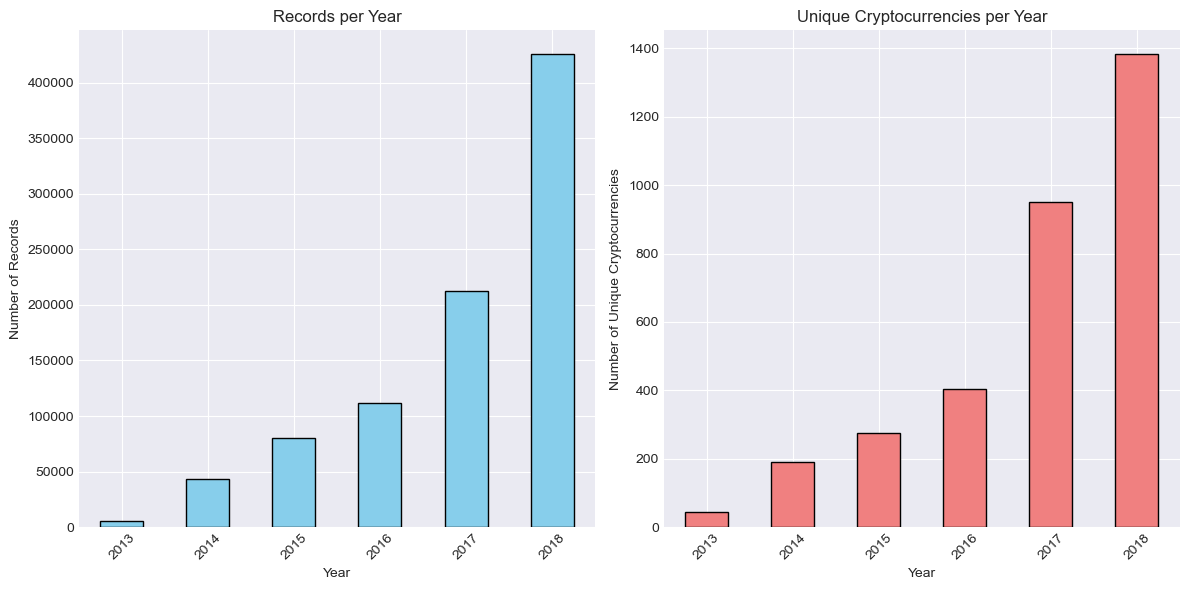

In [14]:
# Visualize data distribution across years
plt.figure(figsize=(12, 6))

# Records per year
plt.subplot(1, 2, 1)
year_counts = df_filtered.groupby('year').size()
year_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.title('Records per Year')
plt.xticks(rotation=45)

# Unique cryptos per year
plt.subplot(1, 2, 2)
year_cryptos = df_filtered.groupby('year')['slug'].nunique()
year_cryptos.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Number of Unique Cryptocurrencies')
plt.title('Unique Cryptocurrencies per Year')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [15]:
# Save metadata for feature engineering
# Helper function to convert numpy types to native Python types
def convert_to_native_types(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    import numpy as np
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: convert_to_native_types(value) for key, value in obj.items()}
    else:
        return obj

# Create metadata dictionary
metadata = {
    'total_cryptos': df_filtered['slug'].nunique(),
    'date_range': {
        'start': str(df_filtered['date'].min()),
        'end': str(df_filtered['date'].max())
    },
    'valid_cryptos': valid_cryptos,
    'years': years,
    'min_days_required': MIN_DAYS_REQUIRED
}

# Convert all numpy types to native Python types
metadata = convert_to_native_types(metadata)

# Debug: Check types
print("Checking data types in metadata:")
for key, value in metadata.items():
    print(f"{key}: {type(value)}")
    if key == 'years':
        print(f"  First year type: {type(value[0]) if value else 'empty'}")
    if key == 'valid_cryptos':
        print(f"  First crypto type: {type(value[0]) if value else 'empty'}")

import json
with open('../data/processed/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("\nMetadata saved for feature engineering phase.")

Checking data types in metadata:
total_cryptos: <class 'int'>
date_range: <class 'dict'>
valid_cryptos: <class 'list'>
  First crypto type: <class 'str'>
years: <class 'list'>
  First year type: <class 'int'>
min_days_required: <class 'int'>

Metadata saved for feature engineering phase.
